In this notebook, we'll code our first Deep Reinforcement Learning agent from scratch to play FrozenLake using deep Q-Learning (DQL)

## Objectives of this code 🏆

- Be able to use **Gymnasium**, the environment library.
- Be able to code a Deep Q-Learning agent from scratch.


In [ ]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 4.1 MB/s eta 0:00:00


In [ ]:
#import packages
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import warnings
import os
from keras.optimizers import Adam
from keras.layers import Dense
from keras.models import Sequential
from collections import deque

# Part 1: Frozen Lake (non slippery version)

## Create and understand [FrozenLake environment ⛄]((https://gymnasium.farama.org/environments/toy_text/frozen_lake/)
---

💡 A good habit when you start to use an environment is to check its documentation

👉 https://gymnasium.farama.org/environments/toy_text/frozen_lake/

---

We're going to train our DQL agent **to navigate from the starting state (S) to the goal state (G) by walking only on frozen tiles (F) and avoid holes (H)**.

We can have two sizes of environment:

- `map_name="4x4"`: a 4x4 grid version
- `map_name="8x8"`: a 8x8 grid version


The environment has two modes:

- `is_slippery=False`: The agent always moves **in the intended direction** due to the non-slippery nature of the frozen lake (deterministic).
- `is_slippery=True`: The agent **may not always move in the intended direction** due to the slippery nature of the frozen lake (stochastic).

For this code, let's keep it simple with the 4x4 map and non-slippery.
We add a parameter called `render_mode` that specifies how the environment should be visualised. As [explained in the documentation](https://gymnasium.farama.org/api/env/#gymnasium.Env.render) “rgb_array”: Return a single frame representing the current state of the environment. A frame is a np.ndarray with shape (x, y, 3) representing RGB values for an x-by-y pixel image.

In [ ]:
#TODO: Based on gymnasium documentation:Create the FrozenLake-v1 environment using 4x4 map and non-slippery version and render_mode="rgb_array"
# Consider the followinf custom_map
custom_map = [
    'FFFF',
    'FFFH',
    'FFFF',
    'FFFG'
]

env = gym.make("FrozenLake-v1", desc=custom_map, is_slippery=False, render_mode="rgb_array")

/usr/local/lib/python3.10/dist-packages/gymnasium/envs/toy_text/frozen_lake.py:237: RuntimeWarning: invalid value encountered in divide
  self.initial_state_distrib /= self.initial_state_distrib.sum()


Let's try to plot  the initial state of the environment by running the following cell:

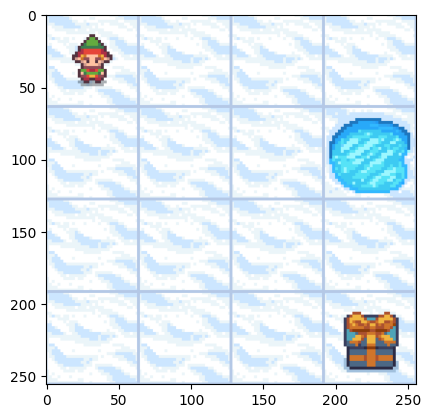

In [ ]:
#plot initial grid
env.reset()
plt.imshow(env.render())

In [ ]:
# Move right
env.step(2)

(1, 0.0, False, False, {'prob': 1.0})

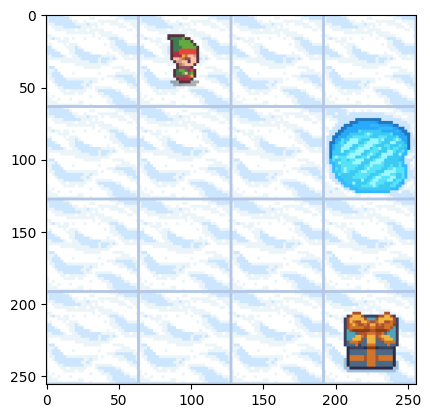

In [ ]:
plt.imshow(env.render())

In [ ]:
# check the observation space
print("_____OBSERVATION SPACE_____ \n")
print("Observation Space", env.observation_space)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

Observation Space Discrete(16)
Sample observation 0


We see with `Observation Space Shape Discrete(16)` that the observation is an integer representing the **agent’s current position as current_row * ncols + current_col (where both the row and col start at 0)**.

For example, the goal position in the 4x4 map can be calculated as follows: 3 * 4 + 3 = 15. The number of possible observations is dependent on the size of the map. **For example, the 4x4 map has 16 possible observations.**

In [ ]:
# TODO Now check the action space
print("\n _____ACTION SPACE_____ \n")
print("Action Space Shape", env.action_space.n)
print("Action Space Sample", env.action_space.sample()) # Take a random action


 _____ACTION SPACE_____ 

Action Space Shape 4
Action Space Sample 1


The action space (the set of possible actions the agent can take) is discrete with 4 actions available 🎮:
- 0: GO LEFT
- 1: GO DOWN
- 2: GO RIGHT
- 3: GO UP

Reward function 💰:
- Reach goal: +1
- Reach hole: 0
- Reach frozen: 0

# Part 2: Design DQL-based agent

Design a DQL agent.
Consider the following DQLAgent class

In [ ]:
class DQLAgent:
    def __init__(self, state_size, action_size):
        self.memory = deque(maxlen=2500)
        self.learning_rate=0.001
        self.epsilon=1
        self.max_eps=1
        self.min_eps=0.01
        self.eps_decay = 0.001/3
        self.gamma=0.9
        self.state_size= state_size
        self.action_size= action_size
        self.epsilon_lst=[]
        self.model = self.buildmodel()
        self.loss_mse = []

    def buildmodel(self):
      model = Sequential()
      model.add(Dense(10, input_dim=self.state_size, activation='relu'))
      model.add(Dense(self.action_size, activation='linear'))
      model.compile(loss='mean_squared_error', optimizer=Adam(lr=self.learning_rate))
      return model

    def add_memory(self, new_state, reward, done, state, action):
        # add the uple (s', r, done, s, a) to the replay buffer
        self.memory.append((new_state, reward, done, state, action))


    def action(self, state):
        # take an action using the epsilon-greedy policy
        ## As usual, first we randomize a number
        ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
        # action based on exploration
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        else:
            return self.pred(state)

    def pred(self, state):
        return np.argmax(self.model.predict(state))

    def replay(self,batch_size):
        minibatch=random.sample(self.memory, batch_size)
        for new_state, reward, done, state, action in minibatch:
            if done:
              target=reward
            else:
                target=reward + self.gamma * np.max(self.model.predict(new_state)[0])
            target_f= self.model.predict(state)
            target_f[0][action]= target
            # Now update the weights of the model, consider epochs=1
            hist = self.model.fit(state, target_f, epochs=1, verbose=1)
            self.loss_mse+=hist.history['loss']

    def update_epsilon(self,episode):
        #update the value of epsilon
        if self.epsilon > self.min_eps:
            self.epsilon=(self.max_eps - self.min_eps) * np.exp(-self.eps_decay*episode) + self.min_eps

        self.epsilon_lst.append(self.epsilon)



# Part 3: Training Phase

###The objective of this section is to design a training loop for the agent.

###a) Complete the TODO parts in the cell above. The hyperparameters for training are given below

###b) Plot the loss function as a function of the number of trainign iterations

###c) plot the rewards as a function of the episodes

###d) Plot the number of steps needed until the end of the episode as a function of the episodes (i.e., x-axis: episodes; y-axis:number of steps needed until the end of the episode)

###e) Plot the profile of epsilon throughout the training





In [ ]:
# The hyperparameters
train_episodes=500
test_episodes=100
max_steps=99

In [ ]:
state_size = env.observation_space.n
action_size = env.action_space.n
batch_size=32

In [ ]:
agent=DQLAgent(state_size, action_size)

rewards=[]
steps=[]

for episode in range(train_episodes):
    state, _= env.reset()
    step=0
    state_arr=np.zeros(state_size)
    state_arr[state] = 1
    state= np.reshape(state_arr, [1, state_size])
    reward = 0
    done = False
    for t in range(max_steps):
        action =agent.action(state)
        new_state, reward, done, _ , _ = env.step(action)

        new_state_arr = np.zeros(state_size)
        new_state_arr[new_state] = 1
        new_state = np.reshape(new_state_arr, [1, state_size])
        agent.add_memory(new_state, reward, done, state, action)
        agent.update_epsilon(episode)



        state= new_state
        step+=1

        if done:
            print(f'Episode: {episode:4}/{train_episodes} and step: {t:4}. Eps: {float(agent.epsilon):.2}, reward {reward}')
            break

    rewards.append(reward)
    steps.append(step)

    if len(agent.memory)> batch_size:
        agent.replay(batch_size)

print(' Train mean % score= ', round(100*np.mean(rewards),1))


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
1/1 [==============================] - 0s 25ms/step
Episode:  450/500 and step:    5. Eps: 0.86, reward 0.0
1/1 [==============================] - 0s 24ms/step
Episode:  451/500 and step:   22. Eps: 0.86, reward 1.0
1/1 [==============================] - 0s 29ms/step
Episode:  452/500 and step:   11. Eps: 0.86, reward 0.0
1/1 [==============================] - 0s 44ms/step
Episode:  453/500 and step:   20. Eps: 0.86, reward 1.0
1/1 [==============================] - 0s 26ms/step
Episode:  454/500 and step:   21. Eps: 0.86, reward 0.0
1/1 [==============================] - 0s 26ms/step
Episode:  455/500 and step:   28. Eps: 0.86, reward 1.0
1/1 [==============================] - 0s 29ms/step
Episode:  456/500 and step:    8. Eps: 0.86, reward 0.0
1/1 [==============================] - 0s 27ms/step
Episode:  458/500 and step:   17. Eps: 0.86, reward 0.0
1/1 [==============================] - 0s 25ms/step
Episod

# Part 4: Testing

In this part, once the agent is trained, use it in full exploitation mode in a total of 100 episodes.

a) Print the average success rate of the agent (the percentage of episodes where it reached the goal out of a total of 100 episodes)

b) Plot the obtained reward as a function of the episode.

In [ ]:
# a) Print the average success rate of the agent
test_episodes = 100
success_count = 0

for episode in range(test_episodes):
    state, _ = env.reset()
    state_arr = np.zeros(state_size)
    state_arr[state] = 1
    state = np.reshape(state_arr, [1, state_size])
    reward = 0
    done = False

    for t in range(max_steps):
        action = agent.pred(state)  # Use prediction, as we are in full exploitation mode
        new_state, reward, done, _ , _ = env.step(action)
        new_state_arr = np.zeros(state_size)
        new_state_arr[new_state] = 1
        new_state = np.reshape(new_state_arr, [1, state_size])

        if done:
          if reward==1:
            print("success reached")
            success_count+=1
            break

# Print the average success rate
success_rate = success_count / test_episodes
print(f"Average success rate: {success_rate * 100:.2f}%")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
1/1 [==============================] - 0s 31ms/step
Average success rate: 0.00%


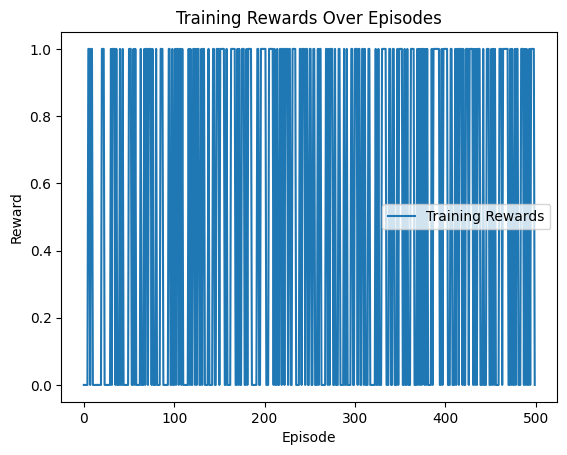

In [ ]:
# b) Plot the obtained reward as a function of the episode
import matplotlib.pyplot as plt

plt.plot(range(train_episodes), rewards, label='Training Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training Rewards Over Episodes')
plt.legend()
plt.show()

#to more calrify


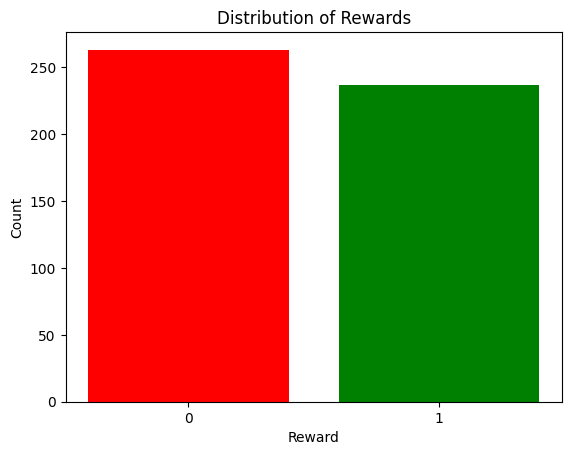

In [ ]:
# Count the occurrences of rewards
reward_counts = {'0': 0, '1': 0}
for reward in rewards:
    if reward == 0:
        reward_counts['0'] += 1
    elif reward == 1:
        reward_counts['1'] += 1

# b) Plot a bar chart of the obtained rewards
reward_labels = list(reward_counts.keys())
reward_values = list(reward_counts.values())

plt.bar(reward_labels, reward_values, color=['red', 'green'])
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Distribution of Rewards')
plt.show()

# Part 5: Target Networks and Soft Updates

###In this part, the aim is to implement an agent that relies on soft-updates rather than har-updates as has been implemented in the parts above. Create a new class entitled `QLAgent_soft` where you implement an agent that uses target networks with soft-updates applied at each step with τ=0.1. Note that `QLAgent_soft` could be implemented by slightly modifying the `QLAgent` class defined above

###a) Train the agent
###b) Implement a testing loop with 100 episodes

#a)QLAgent_soft

In [ ]:
class DQLAgent_soft:
    def __init__(self, state_size, action_size, tau=0.1):
        self.memory = deque(maxlen=2500)
        self.learning_rate = 0.001
        self.epsilon = 1
        self.max_eps = 1
        self.min_eps = 0.01
        self.eps_decay = 0.001/3
        self.gamma = 0.9
        self.state_size = state_size
        self.action_size = action_size
        self.epsilon_lst = []
        self.tau = tau  # Soft update parameter
        self.model = self.buildmodel()
        self.target_model = self.buildmodel()  # Target network

    def buildmodel(self):
        model = Sequential()
        model.add(Dense(10, input_dim=self.state_size, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mean_squared_error', optimizer=Adam(lr=self.learning_rate))
        return model

    def add_memory(self, new_state, reward, done, state, action):
        self.memory.append((new_state, reward, done, state, action))

    def action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        else:
            return self.pred(state)

    def pred(self, state):
        return np.argmax(self.model.predict(state))

    def replay(self, batch_size):
        minibatch = np.array(random.sample(self.memory, batch_size))
        for new_state, reward, done, state, action in minibatch:
            target = reward if done else reward + self.gamma * np.max(self.target_model.predict(new_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)

        # Soft update of target network
        model_weights = np.array(self.model.get_weights())
        target_weights = np.array(self.target_model.get_weights())
        updated_weights = self.tau * model_weights + (1 - self.tau) * target_weights
        self.target_model.set_weights(updated_weights)

    def update_epsilon(self, episode):
        if self.epsilon > self.min_eps:
            self.epsilon = (self.max_eps - self.min_eps) * np.exp(-self.eps_decay * episode) + self.min_eps

        self.epsilon_lst.append(self.epsilon)


# Training the agent

In [ ]:
# Training loop
agent_soft = DQLAgent_soft(state_size, action_size, tau=0.1)

for episode in range(train_episodes):
    state, _ = env.reset()
    state_arr = np.zeros(state_size)
    state_arr[state] = 1
    state = np.reshape(state_arr, [1, state_size])
    reward = 0
    done = False
    for t in range(max_steps):
        action = agent_soft.action(state)
        new_state, reward, done, _ , _ = env.step(action)
        new_state_arr = np.zeros(state_size)
        new_state_arr[new_state] = 1
        new_state = np.reshape(new_state_arr, [1, state_size])
        agent_soft.add_memory(new_state, reward, done, state, action)
        agent_soft.update_epsilon(episode)
        state = new_state

        if done:
          print(f'Episode: {episode:4}/{train_episodes} and step: {t:4}. Eps: {float(agent_soft.epsilon):.2}, reward {reward}')
          break

    if len(agent_soft.memory) > batch_size:
        agent_soft.replay(batch_size)

Episode:    0/500 and step:   11. Eps: 0.85, reward 1.0
Episode:    1/500 and step:    4. Eps: 0.85, reward 0.0
Episode:    2/500 and step:   14. Eps: 0.85, reward 1.0
Episode:    3/500 and step:   19. Eps: 0.85, reward 0.0
1/1 [==============================] - 0s 54ms/step


<ipython-input-20-15f715cc4be7>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  minibatch = np.array(random.sample(self.memory, batch_size))


1/1 [==============================] - 0s 22ms/step
Episode:    4/500 and step:   14. Eps: 0.85, reward 1.0
1/1 [==============================] - 0s 18ms/step


<ipython-input-20-15f715cc4be7>:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  model_weights = np.array(self.model.get_weights())
<ipython-input-20-15f715cc4be7>:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  target_weights = np.array(self.target_model.get_weights())


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
1/1 [==============================] - 0s 26ms/step
Episode:  426/500 and step:   20. Eps: 0.85, reward 0.0
1/1 [==============================] - 0s 24ms/step
Episode:  427/500 and step:   31. Eps: 0.85, reward 0.0
1/1 [==============================] - 0s 31ms/step
Episode:  428/500 and step:    4. Eps: 0.85, reward 0.0
1/1 [==============================] - 0s 23ms/step
Episode:  429/500 and step:   14. Eps: 0.85, reward 0.0
1/1 [==============================] - 0s 27ms/step
Episode:  430/500 and step:   16. Eps: 0.85, reward 0.0
1/1 [==============================] - 0s 36ms/step
Episode:  431/500 and step:   11. Eps: 0.85, reward 1.0
1/1 [==============================] - 0s 18ms/step
Episode:  432/500 and step:   22. Eps: 0.85, reward 1.0
1/1 [==============================] - 0s 29ms/step
Episode:  433/500 and step:   23. Eps: 0.85, reward 1.0
1/1 [==============================] - 0s 42ms/step
Episod

#b)Implement a testing loop with 100 episodes

In [ ]:
# Testing loop
test_episodes = 100
success_count = 0

for episode in range(test_episodes):
    state, _ = env.reset()
    state_arr = np.zeros(state_size)
    state_arr[state] = 1
    state = np.reshape(state_arr, [1, state_size])
    reward = 0
    done = False

    for t in range(max_steps):
        action = agent_soft.pred(state)  # Use prediction, as we are in full exploitation mode
        new_state, reward, done, _ , _ = env.step(action)
        new_state_arr = np.zeros(state_size)
        new_state_arr[new_state] = 1
        new_state = np.reshape(new_state_arr, [1, state_size])

        if done:
            if reward == 1:
                success_count += 1
            break

# Print the average success rate
success_rate = success_count / test_episodes
print(f"Average success rate: {success_rate * 100:.2f}%")

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
1/1 [==============================] - 0s 30ms/step
Average success rate: 0.00%


# **and finally we can continue the same steps done before...**